In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import keras
import numpy as np
from collections import defaultdict
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

Using TensorFlow backend.


In [3]:
# shorthand for each TF name
tfs = ["CTCF", "CEBPA", "Hnf4a", "RXRA"]
# plot-acceptable TF names
tfs_latex_names = ["CTCF", "CEBPα", "HNF4α", "RXRα"]

# shorthand names for all model types to include in plots
all_trainspecies = ["mm10", "DA", "hg38", "NS"]
# plot-acceptable names for model types
model_names_dict = {"mm10" : "Mouse-trained",
                    "hg38" : "Human-trained",
                    "DA" : "Mouse-trained (+DA)",
                    "NS" : "Human-trained (no-SINEs)"}

# If you don't care about testing the model on all examples
# and want to speed things up, uyou can set SKIP to not None;
# every SKIP-th example will be used in model evaluation.
# Be careful -- make sure that *everywhere* in the code,
# the same SKIP value is being used!
SKIP = None
MODEL_TYPE = "best"  # used to use early stopping but not anymore

In [4]:
# needed to load DA models

from flipGradientTF import GradientReversal
import tensorflow

def custom_loss(y_true, y_pred):
    y_pred = tensorflow.boolean_mask(y_pred, tensorflow.not_equal(y_true, -1))
    y_true = tensorflow.boolean_mask(y_true, tensorflow.not_equal(y_true, -1))
    return keras.losses.binary_crossentropy(y_true, y_pred)

In [5]:
from keras.utils import Sequence
from seqdataloader.batchproducers.coordbased.core import Coordinates
from seqdataloader.batchproducers.coordbased.coordstovals.fasta import PyfaidxCoordsToVals

ROOT = "/users/kcochran/projects/domain_adaptation/"

GENOMES = {"mm10" : "/users/kcochran/genomes/mm10_no_alt_analysis_set_ENCODE.fasta",
            "hg38" : "/users/kcochran/genomes/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"}


def get_test_bed_file(species):
    # This function returns the path to a BED-format file
    # containing the chromosome names, starts, and ends for
    # all examples to test the model with.
    # Note this is not specific to any TF (binding labels
    # are loaded in separately).
    return(ROOT + "data/" + species + "/chr2.bed")

class ValGenerator(Sequence):
    # This generator retrieves all coordinates for windows in the test set
    # and converts the sequences in those windows to one-hot encodings.
    # Which species to retrieve test windows for is specified with
    # the "val_species" argument. 
    
    def __init__(self, batchsize, val_species = "hg38", skip = None):
        self.valfile = get_test_bed_file(val_species)
        self.get_steps(skip, batchsize)
        self.converter = PyfaidxCoordsToVals(GENOMES[val_species])
        self.batchsize = batchsize
        self.get_coords(skip)
        
        
    def get_steps(self, skip, batchsize):
        # calculates the number of steps needed to get through
        # all batches of examples in the test dataset
        # (Keras predict_generator code needs to know this)
        with open(self.valfile) as f:
            lines_in_file = sum(1 for line in f)
        if skip is None:
            self.steps = lines_in_file // batchsize
        else:
            self.steps = (lines_in_file // skip) // batchsize

    def __len__(self):
        return self.steps

    def get_coords(self, skip):
        # load all coordinates for the test data into memory
        with open(self.valfile) as f:
            if skip is None:
                coords_tmp = [line.rstrip().split()[:3] for line in f]
            else:
                coords_tmp = [line.rstrip().split()[:3] for i, line in enumerate(f) if i % skip == 0]
            assert [len(line_split) == 3 for line_split in coords_tmp]
            self.coords = [Coordinates(coord[0], int(coord[1]), int(coord[2])) for coord in coords_tmp]

    def __getitem__(self, batch_index):
        # convert a batch's worth of coordinates into one-hot sequences
        batch = self.coords[batch_index * self.batchsize : (batch_index + 1) * self.batchsize]
        return self.converter(batch)
    

def get_preds_batched_fast(model, batch_size, test_species = "hg38"):
    # Make predictions for all test data using a specified model.
    # Batch_size can be as big as your compute can handle.
    # Use test_species = "mm10" to test on mouse data instead of human data.
    
    # NOTE the use of SKIP here -- needs to be consistent everywhere in this notebook!
    print("Generating predictions...")
    return np.squeeze(model.predict_generator(ValGenerator(batch_size, test_species, SKIP),
                                               use_multiprocessing = True, workers = 8, verbose = 1))


In [ ]:
### File and Model Loading

def get_test_file(tf, species):
    # should be in BED file format
    # this file is specific to each tf -- the last column
    # should contain the binding label for each window
    return(ROOT + "data/" + species + "/" + tf + "/chr2.bed")


def get_model_file(tf, train_species, run = 1, model_type = MODEL_TYPE):
    # This function returns the filepath where the model for a given
    # TF, training species, and run is saved.
    # By default, the file for the best model across all training epochs
    # is returned, you can change model_type to select the last model instead.
    # This function specifically looks for the most recent model file,
    # if there are multiple for the same run-TF-species combo.
    try:
        run_int = int(run)
    except:
        print("Error: You need to pass in a run number that can be cast to int.")
    
    model_file_prefix = ROOT + "/".join(["models", tf, train_species + "_trained", "basic_model/"])
        
    if train_species == "DA":
        model_file_prefix = model_file_prefix.replace("DA", "mm10")  # assuming all DA models are mouse-trained
        model_file_prefix = model_file_prefix.replace("basic_model", "DA")
    if train_species == "NS":
        model_file_prefix = model_file_prefix.replace("basic_model", "basic_model_nosines")
        model_file_prefix = model_file_prefix.replace("NS", "hg38")        
    
    # leftover from when I tried early stopping models instead
    if model_type == "earlystop":
        model_file_suffix = "_run" + str(run) + "_earlystop.model"
    elif model_type == "best":
        model_file_suffix = "_run" + str(run) + "_best.model"
    else:
        model_file_suffix = "_run" + str(run) + "_15E_end.model"
    
    files = [f for f in os.listdir(model_file_prefix) if f.endswith(model_file_suffix)]
    # sort files and return the one that is most recent
    latest_file = max([model_file_prefix + f for f in files], key=os.path.getctime)
    return latest_file


def load_keras_model(model_file, DA = False):
    print("Loading " + model_file + ".")
    if DA:
        return keras.models.load_model(model_file,
                custom_objects = {"GradientReversal":GradientReversal,
                                  "custom_loss":custom_loss})
    return keras.models.load_model(model_file)


def get_models_all_runs(tf, train_species):
    # load in models for all runs, for a given TF and training species
    # returns a list of Keras model objects
    files = [get_model_file(tf, train_species, run + 1) for run in range(5)]
    if train_species == "DA":
        return [load_keras_model(f, DA = True) for f in files]
    return [load_keras_model(f) for f in files]

In [6]:
### Model prediction functions

def get_test_labels(tf, species, skip = None):
    # This function reads in the test-data bed file 
    # for a given species and TF and returns the binding labels
    # for each example in that file.
    # Note that if you change SKIP elsewhere in the code,
    # you must change it in the argument to this function too!
    
    print("Loading labels for " + tf + " (" + species + ") using skip = " + str(skip) + "...")
    labels_file = get_test_file(tf, species)
    with open(labels_file) as f:
        if skip is None:
            return np.array([int(line.split()[-1]) for line in f])
        else:
            return np.array([int(line.split()[-1]) for i, line in enumerate(f) if i % skip == 0])
        

def get_auPRCs(preds, labels, DA = False):
    # This function calculates the auPRC for each set of
    # predictions passed in. The length of the 2nd axis
    # of the predictions array passed in will be the # of
    # auPRCs returned as a list. The length of the 1st axis
    # of the predictions array should match the length
    # of the labels array.
    if DA:
        # DA models return 2 predictions for each example:
        # 1 for the binding task and 1 for the species task.
        # we only want the binding predictions
        preds = [model_preds[0] for model_preds in preds]
    assert len(preds[0]) <= len(labels), (preds.shape, labels.shape)
    if len(preds[0]) < len(labels):
        labels = labels[:len(preds[0])]
    return [average_precision_score(labels, model_preds) for model_preds in preds]


def get_auPRC_df(preds_dict, test_species, skip, train_species_list): 
    # This function loads in binding labels for each TF for 
    # a given test species, and for each TF, calculates the auPRC
    # using each set of predictions that is input in "preds_dict".
    auPRC_dicts = defaultdict(lambda : dict())

    for tf in tfs:
        # Note that if you change SKIP elsewhere in the code,
        # you must change it in the argument to this function too!
        test_labels = get_test_labels(tf, test_species, skip = skip)
        for species in train_species_list:
            auPRC_dicts[species][tf] = get_auPRCs(preds_dict[species][tf],
                                                  test_labels,
                                                  DA = species == "DA")
    # before returning all the auPRCs in dictionaries,
    # we just need to reformat how they are stored
    # because seaborn expects particularly formatted input
    return format_data_for_seaborn(auPRC_dicts, train_species_list)

    
### Plot preprocessing functions

def format_data_for_seaborn(auPRC_dicts, train_species_list):
    # This function re-formats the "auPRC_dicts" list of dicts
    # into one pandas DataFrame that matches how seaborn expects
    # data to be input for the plot we will be making
    tf_col = []
    species_col = []
    auprc_col = []
    # assumes reps are constant across training species and TFs
    reps = len(auPRC_dicts[list(auPRC_dicts.keys())[0]][tfs[0]])
    
    for tf in tfs:
        tf_col.extend([tf] * reps * len(train_species_list))
        for species in train_species_list:
            species_col.extend([model_names_dict[species]] * reps)
            auprc_col.extend(auPRC_dicts[species][tf])
        
    return pd.DataFrame({"TF":tf_col, "Species":species_col, "auPRC":auprc_col})

In [7]:
### This cell takes a while (hours) to run.

# First, we will generate predictions for all models on HUMAN test data.

all_preds_human_test = defaultdict(lambda: dict())

# loop over mouse-trained, human-trained models, and DA mouse-trained models
for a_trainspecies in all_trainspecies:  
    for tf in tfs:
        print("\n=====", tf, a_trainspecies, "=====\n")

        models = get_models_all_runs(tf, a_trainspecies)
        # generate predictions for all 5 independent model runs on human data
        all_model_preds = np.array([get_preds_batched_fast(model, 1024) for model in models])
        # store predictions in dictionary
        all_preds_human_test[a_trainspecies][tf] = all_model_preds
        
        # clear variables and model to avoid unnecessary memory usage
        del all_model_preds, tf, models
        keras.backend.clear_session()
    del a_trainspecies


===== CTCF mm10 =====

Loading models...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_16-21-33_run1_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_17-16-29_run2_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_18-11-29_run3_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_19-06-35_run4_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_20-01-19_run5_best.model...
Generating predictions...
Loading coords from file
Done loading coords
4230/4230 [==============================] - 221s 52ms/step
Generating predictions...
Loading coords from file
Done loading coords
4230/4230 [==============================] - 220s 52ms/step
Generating predictions...
Loading coords from file
Done loadi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 217s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
1444/4230 [=========>....................] - ETA: 2:25

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3877/4230 [==========================>...] - ETA: 18s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 216s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
1665/4230 [==========>...................] - ETA: 2:14

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 212s 50ms/step
Generating predictions...
Loading coords from file
Done loading coords
3392/4230 [=======================>......] - ETA: 42s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 214s 50ms/step
(5, 4331520)

===== CEBPA hg38 =====

Loading models...
Loading /users/kcochran/projects/domain_adaptation/models/CEBPA/hg38_trained/basic_model/2020-08-12_18-25-15_run1_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CEBPA/hg38_trained/basic_model/2020-08-12_19-18-48_run2_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CEBPA/hg38_trained/basic_model/2020-08-12_20-12-20_run3_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CEBPA/hg38_trained/basic_model/2020-08-12_21-05-45_run4_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CEBPA/hg38_trained/basic_model/2020-08-12_21-59-01_run5_best.model...
Generating predictions...
Loading coords from file
Done loading coords
3744/4230 [=========================>....] - ETA: 24s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 217s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
3097/4230 [====================>.........] - ETA: 57s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 211s 50ms/step
Generating predictions...
Loading coords from file
Done loading coords
2448/4230 [================>.............] - ETA: 1:30

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 214s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
2321/4230 [===============>..............] - ETA: 1:36

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 218s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
1730/4230 [===========>..................] - ETA: 2:06

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 215s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
4020/4230 [===========================>..] - ETA: 10s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 211s 50ms/step
Generating predictions...
Loading coords from file
Done loading coords
3587/4230 [========================>.....] - ETA: 32s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 216s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
3780/4230 [=========================>....] - ETA: 22s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 211s 50ms/step
Generating predictions...
Loading coords from file
Done loading coords
3644/4230 [========================>.....] - ETA: 29s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4230/4230 [==============================] - 216s 51ms/step
(5, 4331520)


In [9]:
# process predictions into auPRCs for every model tested on HUMAN data
human_test_df = get_auPRC_df(all_preds_human_test, "hg38", SKIP, all_trainspecies)

# to avoid repeatedly running the cell above, save results to a file
#human_test_df.to_csv("plot_data/hg38_test_all_auPRCs.csv")

Loading labels for CTCF (hg38) using skip = None...
Loading labels for CEBPA (hg38) using skip = None...
Loading labels for Hnf4a (hg38) using skip = None...
Loading labels for RXRA (hg38) using skip = None...


In [ ]:
# Plotting code

# Constants to specify plot appearance details
DOT_SIZE = 5
FIG_SIZE_UNIT = 5
FIG_SIZE = (FIG_SIZE_UNIT + 1.5, FIG_SIZE_UNIT - 1)
FIG_SIZE_SMALL = (FIG_SIZE_UNIT, FIG_SIZE_UNIT - 1)
COLORS = ["#0062B8", "#8FFFA3", "#FF0145", "#FFF587"]
AX_FONTSIZE = 16
AXTICK_FONTSIZE = 13
TITLESIZE = 17


def make_boxplot(df, species, save_files = False, include = [],
                 fig_size = FIG_SIZE, colors_to_use = COLORS,
                 dot_size = DOT_SIZE, titlesize = TITLESIZE,
                 ax_fontsize = AX_FONTSIZE,
                 axtick_fontsize = AXTICK_FONTSIZE):
    
    # This function creates one boxplot using seaborn.
    # The data plotted must be stored in a pandas DataFrame (input = "df"),
    # including 3 columns: TF, Species, and auPRC (case-sensitive names).

    # Use the argument save_files to toggle between saving plots
    # and outputting them within the notebook.
    
    # If you want to create a plot containing only a subset of the data
    # in your input DataFrame, specify which training species / model types
    # to include by listing the model types by name in a list and give
    # to the argument "include" (see cell below for examples). Plotting
    # will follow the order of the model types as they are listed in "include".
    
    
    # determine y-axis upper limit of plots
    # this is done before data is subsetted to keep axis consistent
    # regardless of which subset of data is used
    yax_max = max(df["auPRC"]) + 0.05
    
    # include should have species to plot in order of how you want them sorted on plot
    if len(include) > 0:
        model_names_include = set([model_names_dict[species] for species in include])
        df_to_use = df[[species in model_names_include for species in df["Species"]]]
        cols_list = []
        for index, col in enumerate(colors_to_use):
            if all_trainspecies[index] in include:
                cols_list.append(col)
        cols = sns.color_palette(cols_list)
    else:
        df_to_use = df
        cols = sns.color_palette(colors_to_use)
    
    sns.set(style = "white")

    # first, draw boxplots
    ax = sns.boxplot(x = "TF", y = "auPRC", hue = "Species",
                     data = df_to_use,
                     showfliers = False,
                     palette = cols)
    # add legend and store in variable
    ax.legend(loc = 'upper right', ncol = 1, frameon = False)
    legend = ax.legend_

    # next, add individual dots over boxplots
    ax = sns.swarmplot(x = "TF", y = "auPRC", hue = "Species",
                       data = df_to_use,
                       dodge = True,
                       palette = cols,
                       size = dot_size,
                       edgecolor = "0.25",
                       linewidth = 1.5)
    # restore legend to the boxplot version (removes swarmplot legend)
    ax.legend_ = legend

    # format and label axes
    ax.set_xlabel("", fontsize = 0)
    ax.set_ylabel("Area Under PRC", fontsize = ax_fontsize)
    ax.set_xticklabels(labels = tfs_latex_names, fontsize = ax_fontsize)
    ax.tick_params(axis='y', which='major', pad = -2, labelsize = axtick_fontsize)
    plt.ylim(0, yax_max) # limit is hard-coded so that it's constant across all plots
    plt.yticks([0, 0.2, 0.4, 0.6])
    
    # modify font size if there isn't much to plot
    if len(include) < 3:
        titlesize = titlesize - 2
    
    # use plot-acceptable version of test data species name
    # e.g. "mm10" --> "Mouse"
    title = "Model Performance, "
    title += r"$\bf{" + model_names_dict[species].replace("-trained", "") + "}$"
    title += " Test Data"
    plt.title(title, fontsize = titlesize)
        
    if include is None:
        save_suffix = "all"
    else:
        save_suffix = ",".join(include)

    if not save_files:
        plt.show()
    else:
        # if you only want png or pdf, comment out some of these
        plt.savefig("../plots/boxplots_" + species + "_test_highres_" + save_suffix + ".eps",
                    bbox_inches='tight', pad_inches = 0.1, dpi = 1200)
        plt.savefig("../plots/boxplots_" + species + "_test_" + save_suffix + ".eps",
                    bbox_inches='tight', pad_inches = 0.1, dpi = 350)
        plt.savefig("../plots/boxplots_" + species + "_test_" + save_suffix + ".png",
                    bbox_inches='tight', pad_inches = 0.1, dpi = 300)
        plt.savefig("../plots/boxplots_" + species + "_test_" + save_suffix + ".pdf",
                    bbox_inches='tight', pad_inches = 0.1)

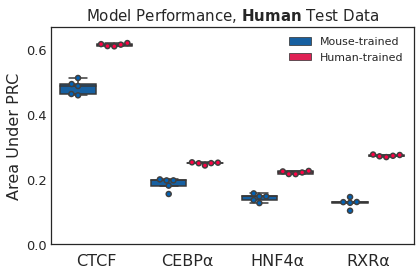

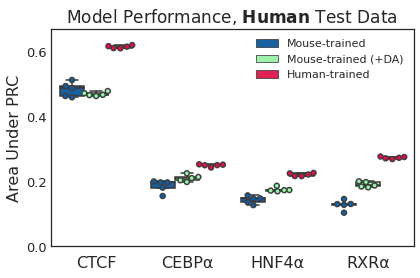

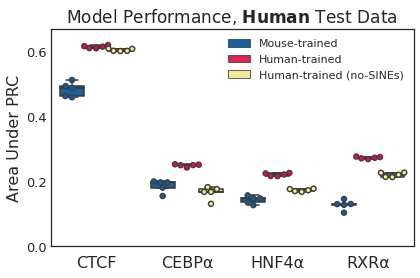

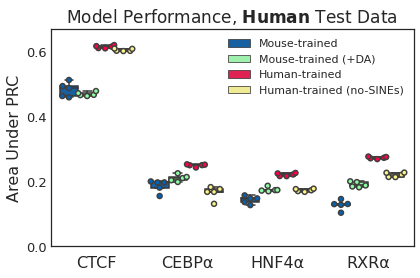

In [11]:
# listing out all the groups of model types (training species)
# to make plots with
include_list_all = [
    ["mm10", "hg38"],
    ["mm10", "DA", "hg38"],
    ["mm10", "NS", "hg38"],
    ["mm10", "DA", "hg38", "NS"]
]


for index, include_list in enumerate(include_list_all):
    sns.set(rc = {'figure.figsize' : FIG_SIZE})
    plt.figure(index)
    make_boxplot(human_test_df, "hg38", save_files = True, include = include_list)

In [8]:
### This cell takes about awhile (hour+) to run.

# Now repeat the entire process for MOUSE test data.

all_preds_mouse_test = defaultdict(lambda: dict())

for a_trainspecies in ["mm10", "DA", "hg38"]:
    for tf in tfs:
        print("\n=====", tf, a_trainspecies, "=====\n")

        print("Loading models...")
        models = get_models_all_runs(tf, a_trainspecies)
        # generate predictions for all models on MOUSE test data
        all_model_preds = np.array([get_preds_batched_fast(model, 1024, "mm10") for model in models])
        # save predictions in dictionary
        all_preds_mouse_test[a_trainspecies][tf] = all_model_preds
        # clear memory
        del all_model_preds, tf, models
        keras.backend.clear_session()

    del a_trainspecies


===== CTCF mm10 =====

Loading models...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_16-21-33_run1_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_17-16-29_run2_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_18-11-29_run3_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_19-06-35_run4_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/CTCF/mm10_trained/basic_model/2020-08-12_20-01-19_run5_best.model...
Generating predictions...
Loading coords from file
Done loading coords
3084/3084 [==============================] - 164s 53ms/step
Generating predictions...
Loading coords from file
Done loading coords
3084/3084 [==============================] - 162s 53ms/step
Generating predictions...
Loading coords from file
Done loadi

Loading /users/kcochran/projects/domain_adaptation/models/Hnf4a/mm10_trained/DA/2020-08-14_01-02-17_run3_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/Hnf4a/mm10_trained/DA/2020-08-14_05-28-07_run4_best.model...
Loading /users/kcochran/projects/domain_adaptation/models/Hnf4a/mm10_trained/DA/2020-08-14_09-36-35_run5_best.model...
Generating predictions...
Loading coords from file
Done loading coords
3084/3084 [==============================] - 159s 52ms/step
Generating predictions...
Loading coords from file
Done loading coords
3084/3084 [==============================] - 158s 51ms/step
Generating predictions...
Loading coords from file
Done loading coords
3084/3084 [==============================] - 161s 52ms/step
Generating predictions...
Loading coords from file
Done loading coords
3084/3084 [==============================] - 160s 52ms/step
Generating predictions...
Loading coords from file
Done loading coords
3084/3084 [==============================] - 171

In [12]:
# covnert predictions into auPRCs for every model, on MOUSE test labels
# using the same SKIP here as everywhere else in the notebook
mouse_test_df = get_auPRC_df(all_preds_mouse_test, "mm10", SKIP, ["mm10", "DA", "hg38"])

# optionally, save results to file to save time
#mouse_test_df.to_csv("plot_data/mm10_test_all_auPRCs.csv")

Loading labels for CTCF (mm10) using skip = None...
Loading labels for CEBPA (mm10) using skip = None...
Loading labels for Hnf4a (mm10) using skip = None...
Loading labels for RXRA (mm10) using skip = None...


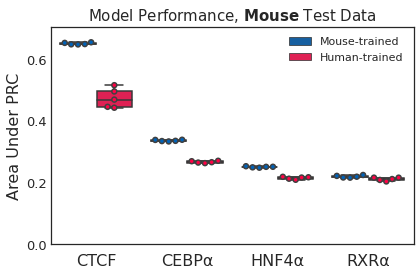

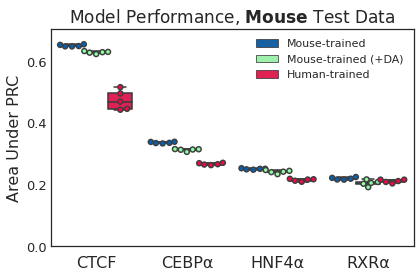

In [13]:
# Generate plots for performance on MOUSE test data
include_list_all = [
    ["mm10", "hg38"],
    ["mm10", "DA", "hg38"]
]

for index, include_list in enumerate(include_list_all):
    sns.set(rc = {'figure.figsize' : FIG_SIZE})
    plt.figure(index)
    make_boxplot(mouse_test_df, "mm10", save_files = True, include = include_list)
    